In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#jax.config.update('jax_platform_name', 'cpu')
#jax.default_device(jax.devices("cpu")[0])

In [2]:
jax.default_device()

In [3]:
jax.default_backend()

I0000 00:00:1695952485.766221   17179 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


'gpu'

In [4]:
jax.default_backend()

'gpu'

In [5]:
key = random.PRNGKey(0)
x = random.normal(key, (10, ))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [6]:
size = 150
x = random.normal(key, (size, size), dtype = jnp.float32)
%timeit jnp.dot(x, x.T).block_until_ready()  # runs on the GPU

216 µs ± 77.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
import numpy as np
x = np.random.normal(size = (size, size)).astype(np.float32)
%timeit jnp.dot(x, x.T).block_until_ready()

87 µs ± 772 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [33]:
key = random.PRNGKey(0)
dt = jnp.float32(0.001)
dt_sqrt = jnp.sqrt(dt)
drift = jnp.float32(2)
drift_increment = drift * dt
bound = jnp.float32(2)

# x = jnp.cumsum((random.normal(key, (10000, 20000)).astype(jnp.float32) * dt_sqrt) + drift, axis = 1)

x = (random.normal(key, (10000, 20000), dtype=jnp.float32))

# @jax.jit
# def prod_rts_from_rng(x, bound, dt, drift):
#     dt_sqrt = jnp.sqrt(dt)
#     drift_increment = drift * dt
#     y = jnp.cumsum((x * dt_sqrt) + drift_increment, axis = 1)
    
#     rt_ids = jnp.argmax((y > bound) | (y < -bound), axis = 1)
#     rt_signs = jnp.sign(y[jnp.arange(y.shape[0]), rt_ids])
#     rts = rt_ids * rt_signs * dt
#     return rts
#     # return rts


@jax.jit
def prod_rts_from_rng(x, bound, dt, drift):
    dt_sqrt = jnp.sqrt(dt)
    drift_increment = drift * dt
    y = jnp.cumsum(x + drift_increment, axis = 1)
    rt_ids = jnp.argmax((y > bound) | (y < -bound), axis = 1)
    rt_signs = jnp.sign(y[jnp.arange(y.shape[0]), rt_ids])
    rts = rt_ids * rt_signs * dt
    return rts
    # return rts

In [11]:

key = random.PRNGKey(0)
def test_func(min_num, max_num, key, pos_init, bound):
    @jax.jit
    def body_fun(n, carry):
        key, pos, mask, bound, rts, dec, step_counter = carry
        step_counter = step_counter + 1
        key, subkey = random.split(key)
        ran_val = random.normal(key, (200000,), dtype=jnp.float32)
        pos = pos + ran_val
        ok_mask = (pos < bound) | (pos > -bound) * mask
        rts = jnp.min(rts, step_counter * ok_mask)
        dec = jnp.sign(pos) * ok_mask
        return (subkey, pos, ok_mask, bound, rts, dec, step_counter)
    subkey, pos = jax.lax.fori_loop(min_num, max_num, body_fun, (key, pos_init,
                                                                 jnp.array([True]*pos_init.shape[0]), bound, jnp.zeros(pos_init.shape, dtype = jnp.float32), 
                                                                 jnp.zeros(pos_init.shape, dtype = jnp.float32),
                                                                 0))
    return pos

In [102]:

key = random.PRNGKey(0)
def test_func(min_num, max_num, key, pos_init, bound):
    @jax.jit
    def body_fun(n, carry):
        key, pos, mask, bound, mask_int, rts = carry
        #step_counter = step_counter + 1
        key, subkey = random.split(key)
        ran_val = random.normal(key, (200000,), dtype=jnp.float32) * jnp.sqrt(0.001)
        pos = pos + ran_val
        mask = ((pos < bound) & (pos > -bound)) * mask
        mask_int = jnp.float32(n * mask)
        rts = jnp.maximum(rts, mask_int)
        dec.at
        # dec = jnp.sign(pos) * ok_mask
        return (subkey, pos, mask, bound, mask_int, rts)
    subkey, pos, ok_mask, bound, mask_int, rts = jax.lax.fori_loop(min_num, max_num, body_fun, (key, 
                                                                                                pos_init,
                                                                                                jnp.array([True]*pos_init.shape[0]), 
                                                                                                bound, jnp.array([0.]*pos_init.shape[0]),
                                                                                                jnp.array([0.]*pos_init.shape[0])))
    return pos, ok_mask, mask_int, rts

In [5]:
key = random.PRNGKey(0)
def test_func(min_num, max_num, key, pos_init, bound):
    @jax.jit
    def body_fun(n, carry):
        key, pos, mask, bound, mask_int, rts, dec = carry
        #step_counter = step_counter + 1
        key, subkey = random.split(key)
        ran_val = random.normal(key, (200000,), dtype=jnp.float32) * jnp.sqrt(0.001)
        pos = pos + ran_val
        mask = ((pos < bound) & (pos > -bound)) * mask
        mask_int = jnp.float32(n * mask)
        rts = jnp.maximum(rts, mask_int)
        dec = jnp.where(rts == mask_int, jnp.sign(pos), dec)
        return (subkey, pos, mask, bound, mask_int, rts, dec)
    subkey, pos, ok_mask, bound, mask_int, rts, dec  = jax.lax.fori_loop(min_num, max_num, body_fun, (key, 
                                                                                                      pos_init,
                                                                                                      jnp.array([True]*pos_init.shape[0]), 
                                                                                                      bound, jnp.array([0.]*pos_init.shape[0]),
                                                                                                      jnp.array([0.]*pos_init.shape[0]),
                                                                                                      jnp.array([0.]*pos_init.shape[0])))
    return pos, ok_mask, mask_int, rts, dec

In [65]:
key = random.PRNGKey(0)
def test_func(min_num, max_num, key, dt, ndt, pos_init, bounds, drifts, biases): # bias ignored for now
    keys = random.split(key, 20000)
    drifts_internal = drifts * dt
    n_bounds = jnp.max(jnp.array(bounds.shape))
    n_drifts = jnp.max(jnp.array(drifts.shape))
    n_particles = jnp.max(jnp.array(pos_init.shape))
    n_biases = jnp.max(jnp.array(biases.shape))

    #pos_init = pos_init.at[:, :, :, :].set( biases)
    #print(pos_init[0, :, :, :])

    pos_init = (-bounds + (2 * bounds * biases)) + pos_init

    #pos_init_internal = -bound[0]
    #ndt = 0.
    
    @jax.jit
    def body_fun(n, carry):
        # Stuff that carries across loop evals
        pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys = carry

        # Shape of ran_val is (n_particles, 1, 1, 1)
        ran_val = random.normal(keys[n], (pos_init.shape[0], 1, 1, 1), dtype=jnp.float32) * jnp.sqrt(dt)
        
        # pos = jax.vamp(lambda x: pos + ran_val + x, axes_out = -1)(drift_internal)
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases)
        # Shape of drift is (1, n_drifts, 1, 1)
        # Shape of bias  is (1, 1, 1, n_biases)
        # Shape of bounds is (1, 1, n_bounds, 1)
        
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases) + (n_particles, 1, 1, 1) + (1, n_drifts, 1, 1)
        pos = pos + ran_val + drifts_internal

        # Shape of mask is (n_particles, n_drifts, n_bounds)
        # mask = jax.vmap(lambda x: (pos < x) & (pos > -x) , out_axes = -1)(bound)
        mask = ((pos < bounds) & (pos > -bounds)) * mask
        
        # From here dimensions clear
        mask_int = jnp.float32(n * mask)

        # Shape of rts (n_particles, n_drifts, n_bounds)
        rts = jnp.maximum(rts, mask_int)

        # Shape of dec (n_particles, n_dirfts, n_bounds)
        #tmp = rts == mask_int
        dec = jnp.where(rts == mask_int, jnp.sign(pos), dec)
        
        return (pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys)
    
    pos, ok_mask, bounds, drifts, biases, mask_int, rts, dec, keys,  = jax.lax.fori_loop(min_num, max_num, body_fun, (pos_init,
                                                                                                           jnp.full((n_particles, n_drifts, n_bounds, n_biases), True), # ok_mask
                                                                                                           bounds,
                                                                                                           drifts,
                                                                                                           biases,
                                                                                                           jnp.full((n_particles, n_drifts, n_bounds, n_biases), 1.),
                                                                                                           jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                           jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                           keys))
    return pos, ok_mask, mask_int, (rts * dt) + ndt, dec

In [10]:
# Allow any drift and any boundary

key = random.PRNGKey(0)
def test_func(min_num, max_num, key, dt, ndt, pos_init, bounds, drifts, biases): # bias ignored for now
    keys = random.split(key, max_num)
    drifts_internal = drifts * dt
    n_bounds = jnp.max(jnp.array(bounds.shape[1:]))
    n_drifts = jnp.max(jnp.array(drifts.shape[1:]))
    n_particles = jnp.max(jnp.array(pos_init.shape))
    n_biases = jnp.max(jnp.array(biases.shape[1:]))

    print(n_bounds)
    
    #pos_init = pos_init.at[:, :, :, :].set( biases)
    #print(pos_init[0, :, :, :])

    pos_init = (-bounds[0] + (2 * bounds[0] * biases)) + pos_init
    print(pos_init.shape)

    #pos_init_internal = -bound[0]
    #ndt = 0.

    @jax.jit
    def propagation_kernel(pos, random_displacements, drift):
        return pos + random_displacements + drift
    
    @jax.jit
    def body_fun(n, carry):
        # Stuff that carries across loop evals
        pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys = carry

        # Shape of ran_val is (n_particles, 1, 1, 1)
        ran_val = random.normal(keys[n], (pos_init.shape[0], 1, 1, 1), dtype=jnp.float32) * jnp.sqrt(dt)
        
        # pos = jax.vamp(lambda x: pos + ran_val + x, axes_out = -1)(drift_internal)
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases)
        # Shape of drift is (1, n_drifts, 1, 1)
        # Shape of bias  is (1, 1, 1, n_biases)
        # Shape of bounds is (1, 1, n_bounds, 1)
        
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases) + (n_particles, 1, 1, 1) + (1, n_drifts, 1, 1)
        pos = propagation_kernel(pos, ran_val, drifts_internal[n])
        #pos = pos + ran_val + drifts_internal[n]
        #print(pos.shape)

        # Shape of mask is (n_particles, n_drifts, n_bounds)
        # mask = jax.vmap(lambda x: (pos < x) & (pos > -x) , out_axes = -1)(bound)
        mask = ((pos < bounds[n]) & (pos > -bounds[n])) * mask
        
        # From here dimensions clear
        mask_int = jnp.float32(n * mask)

        # Shape of rts (n_particles, n_drifts, n_bounds)
        rts = jnp.maximum(rts, mask_int)

        # Shape of dec (n_particles, n_dirfts, n_bounds)
        #tmp = rts == mask_int
        dec = jnp.where(rts == mask_int, jnp.sign(pos), dec)
        
        return (pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys)
    
    pos, ok_mask, bounds, drifts, biases, mask_int, rts, dec, keys,  = jax.lax.fori_loop(min_num, max_num, body_fun, (pos_init,
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), True), # ok_mask
                                                                                                                      bounds,
                                                                                                                      drifts,
                                                                                                                      biases,
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 1.),
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                                      keys))
    return pos, ok_mask, mask_int, (rts * dt) + ndt, dec

In [ ]:
# Allow random drift and boundary across particles

key = random.PRNGKey(0)
def test_func(min_num, max_num, key, dt, ndt, pos_init, bounds, drifts, biases): # bias ignored for now
    keys = random.split(key, max_num)
    drifts_internal = drifts * dt
    n_bounds = jnp.max(jnp.array(bounds.shape[1:]))
    n_drifts = jnp.max(jnp.array(drifts.shape[1:]))
    n_particles = jnp.max(jnp.array(pos_init.shape))
    n_biases = jnp.max(jnp.array(biases.shape[1:]))

    print(n_bounds)
    
    #pos_init = pos_init.at[:, :, :, :].set( biases)
    #print(pos_init[0, :, :, :])

    pos_init = (-bounds[0] + (2 * bounds[0] * biases)) + pos_init
    print(pos_init.shape)

    #pos_init_internal = -bound[0]
    #ndt = 0.

    @jax.jit
    def propagation_kernel(pos, random_displacements, drift):
        return pos + random_displacements + drift

    @jax.jit
    def my_bound(a, t):
        bound = jnp.ones(t.shape[0]) * a
        return jnp.array(bound, dtype = jnp.float32)

    @jax.jit
    def my_drift(v, t):
        drift = jnp.ones(t.shape[0]) * v
        return jnp.array(drift, dtype = jnp.float32)


    @jax.jit
    def drift_fun(v, t):
        jnp.
        return v


    @jax.jit
    def bound_fun()
    
    @jax.jit
    def body_fun(n, carry):
        # Stuff that carries across loop evals
        pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys = carry

        # Shape of ran_val is (n_particles, 1, 1, 1)
        ran_val = random.normal(keys[n], (pos_init.shape[0], 1, 1, 1), dtype=jnp.float32) * jnp.sqrt(dt)
        
        # pos = jax.vamp(lambda x: pos + ran_val + x, axes_out = -1)(drift_internal)
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases)
        # Shape of drift is (1, n_drifts, 1, 1)
        # Shape of bias  is (1, 1, 1, n_biases)
        # Shape of bounds is (1, 1, n_bounds, 1)
        
        # Shape of pos is (n_particles, n_drifts, n_bounds, n_biases) + (n_particles, 1, 1, 1) + (1, n_drifts, 1, 1)
        pos = propagation_kernel(pos, ran_val, drifts_internal[n])
        #pos = pos + ran_val + drifts_internal[n]
        #print(pos.shape)

        # Shape of mask is (n_particles, n_drifts, n_bounds)
        # mask = jax.vmap(lambda x: (pos < x) & (pos > -x) , out_axes = -1)(bound)
        mask = ((pos < bounds[n]) & (pos > -bounds[n])) * mask
        
        # From here dimensions clear
        mask_int = jnp.float32(n * mask)

        # Shape of rts (n_particles, n_drifts, n_bounds)
        rts = jnp.maximum(rts, mask_int)

        # Shape of dec (n_particles, n_dirfts, n_bounds)
        #tmp = rts == mask_int
        dec = jnp.where(rts == mask_int, jnp.sign(pos), dec)
        
        return (pos, mask, bounds, drifts, biases, mask_int, rts, dec, keys)
    
    pos, ok_mask, bounds, drifts, biases, mask_int, rts, dec, keys,  = jax.lax.fori_loop(min_num, max_num, body_fun, (pos_init,
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), True), # ok_mask
                                                                                                                      bounds,
                                                                                                                      drifts,
                                                                                                                      biases,
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 1.),
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                                      jnp.full((n_particles, n_drifts, n_bounds, n_biases), 0.),
                                                                                                                      keys))
    return pos, ok_mask, mask_int, (rts * dt) + ndt, dec

In [11]:
from functools import partial

@jax.jit
def my_bound(a, t):
    bound = jnp.ones(t.shape[0]) * a
    return jnp.array(bound, dtype = jnp.float32)

def bound_with_t(func, t):
    new_func = jax.jit(partial(func, t = t))
    return new_func

@jax.jit
def my_drift(v, t):
    drift = jnp.ones(t.shape[0]) * v
    return jnp.array(drift, dtype = jnp.float32)

def drift_with_t(func, t):
    new_func = jax.jit(partial(func, t = t))
    return new_func

In [16]:
#test_func(min_num = 0, max_num = 20000, key, dt, ndt, pos_init, bound, drift, bias # bias ignored for now
n_particles = 200000
dt = 0.001
n_drifts = 1
n_bounds = 10
n_biases = 1

my_new_bound = bound_with_t(my_bound, t = jnp.arange(20000))
my_bounds = jax.vmap(my_new_bound, in_axes=0, out_axes = -1)(jnp.linspace(1,3,n_bounds))
bounds = jnp.reshape(my_bounds, (20000, 1, 1, n_bounds, 1))


my_new_drift = drift_with_t(my_drift, t = jnp.arange(20000))
my_drifts = jax.vmap(my_new_drift, in_axes = 0, out_axes = -1)(jnp.linspace(-2, 2, n_drifts))
drifts = jnp.reshape(my_drifts, (20000, 1, n_drifts, 1, 1))

#drifts = jnp.reshape(jnp.linspace(-2, 2, n_drifts), (1, n_drifts, 1, 1))

biases = jnp.reshape(jnp.linspace(0.1, 0.9, n_biases), (1, 1, 1, n_biases))

out = test_func(0, 20000, key, dt, 2, jnp.zeros((n_particles, n_drifts, n_bounds, n_biases)), 
                               bounds,
                               drifts,
                               jnp.reshape(jnp.linspace(0.1, 0.9, n_biases), (1, 1, 1, n_biases)))

10
(200000, 1, 10, 1)


In [81]:
jax.vmap(my_new_drift, in_axes = 0, out_axes = -1)(jnp.linspace(-2, 2, n_drifts))

In [50]:
bounds[0].shape

(1, 1, 10, 1)

In [36]:
b = jnp.reshape(jnp.linspace(0.1, 0.9, n_biases), (1, 1, 1, n_biases)) # nbiases
a = jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds, 1)) # bounds

In [11]:
@jax.jit
def my_bound(a, t):
    bound = jnp.ones(t.shape[0]) * a
    return jnp.array(bound, dtype = jnp.float32)

def bound_with_t(func, t):
    new_func = jax.jit(partial(func, t = t))
    return new_func



In [32]:
from functools import partial
my_new_bound = bound_with_t(my_bound, t = jnp.arange(20000))
#my_new_bound = partial(my_bound, t = jnp.arange(20000))
my_bounds = jax.vmap(my_new_bound, in_axes=0, out_axes = -1)(jnp.linspace(1,3,10))
bounds = jnp.reshape(my_bounds, (20000, 1, 1, n_bounds, 1))

In [64]:
out[-1].shape

(100000, 1, 10, 1)

(array([2.32720816e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.49081224e-04, 1.16359763e-04, 0.00000000e+00,
        2.32720816e-04, 3.49081224e-04, 1.16359763e-04, 2.32720816e-04,
        3.49081224e-04, 9.30883265e-04, 3.49079288e-04, 9.30883265e-04,
        1.04724367e-03, 2.90900213e-03, 2.09448735e-03, 3.14172230e-03,
        3.83989347e-03, 6.16708452e-03, 7.09798490e-03, 9.54152700e-03,
        9.89063469e-03, 1.40796094e-02, 1.67558523e-02, 2.28066400e-02,
        2.83918608e-02, 4.34024322e-02, 5.82964028e-02, 7.74960318e-02,
        1.06818558e-01, 1.61275526e-01, 2.35745533e-01, 3.70840621e-01,
        6.16126652e-01, 1.18373443e+00, 2.59890251e+00, 6.05050850e+00,
        3.49080740e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

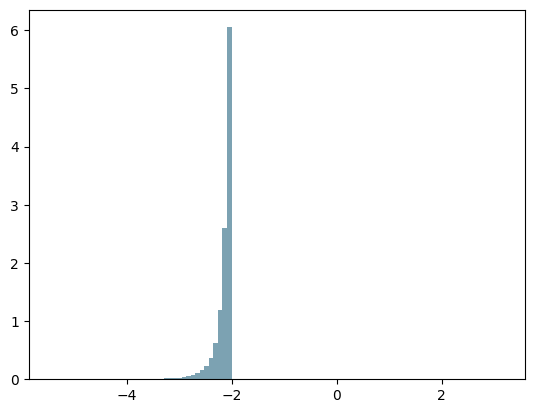

In [62]:
from matplotlib import pyplot as plt
import numpy as np
# plt.hist(np.array(out[-2][:,4, 4, 0] * out[-1][:,4, 4, 0]), bins = 100, alpha = 0.3, color = 'blue')
# plt.hist(np.array(out[-2][:,4, 4, 9] * out[-1][:,4, 4, 9]), bins = 100, alpha = 0.3, color = 'green')
#plt.hist(np.array(out[-2][:,:] * out[-1][:,:]), bins = 100, alpha = 0.3, color = 'red')

# plt.hist(np.array(out[-2][:,0, 0, 4] * out[-1][:,0, 0, 4]), bins = 100, alpha = 0.3, color = 'blue')
# plt.hist(np.array(out[-2][:,0, 9, 4] * out[-1][:,0, 9, 4]), bins = 100, alpha = 0.3, color = 'green')

# drift, bound, bias
plt.hist(np.array(out[-2][:,2, 2, 0] * out[-1][:,2, 2, 0]), bins = 100, alpha = 0.3, color = 'blue', density = True)
plt.hist(np.array(out[-2][:,2, 2, 4] * out[-1][:,2, 2, 4]), bins = 100, alpha = 0.3, color = 'green', density = True)

# plt.hist(np.array(out[-2][:,0, 2, 2] * out[-1][:,0, 2, 2]), bins = 100, alpha = 0.3, color = 'orange')
# plt.hist(np.array(out[-2][:,4, 2, 2] * out[-1][:,4, 2, 2]), bins = 100, alpha = 0.3, color = 'red')

In [174]:
starting_points = jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds)) + ((2 * jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds)) * 0.5))

In [13]:
out[-1].shape

(200000, 10, 10, 10)

In [14]:
out[-2].shape

(200000, 10, 10, 10)

In [188]:
n_biases = 10
biases = jnp.linspace(0.1, 0.9, n_biases)
my_starting_points = jax.vmap(lambda x: jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds)) + ((2 * jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds)) * x)), out_axes = -2)(biases)
#jnp.stack(jnp.linspace(0.1, 0.9, n_biases), (1, n_bounds, n_biases))

In [189]:
my_starting_points.shape

(1, 1, 10, 100)

In [191]:
my_starting_points

Array([[[[1.2      , 1.2242424, 1.2484848, 1.2727274, 1.2969698,
          1.321212 , 1.3454546, 1.369697 , 1.3939393, 1.4181818,
          1.4424242, 1.4666667, 1.4909091, 1.5151515, 1.539394 ,
          1.5636364, 1.587879 , 1.6121212, 1.6363636, 1.6606061,
          1.6848485, 1.7090908, 1.7333333, 1.7575759, 1.7818182,
          1.8060607, 1.8303031, 1.8545456, 1.878788 , 1.9030303,
          1.9272728, 1.9515152, 1.9757576, 2.       , 2.0242424,
          2.048485 , 2.0727272, 2.0969698, 2.1212122, 2.1454546,
          2.169697 , 2.1939394, 2.2181816, 2.2424242, 2.2666667,
          2.290909 , 2.3151517, 2.339394 , 2.3636365, 2.387879 ,
          2.4121213, 2.4363637, 2.460606 , 2.4848485, 2.5090911,
          2.5333333, 2.557576 , 2.5818183, 2.6060605, 2.6303031,
          2.6545455, 2.6787877, 2.7030303, 2.727273 , 2.7515154,
          2.7757576, 2.8      , 2.8242426, 2.8484848, 2.8727274,
          2.89697  , 2.9212122, 2.9454546, 2.9696972, 2.9939394,
          3.0181818, 3.04

In [ ]:
jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds)) - jnp.reshape(jnp.linspace(1, 3, n_bounds), (1, 1, n_bounds))

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.array(out[-2][0,:] * out[-1][0,:]), bins = 100, alpha = 0.3, color = 'blue')
plt.hist(np.array(out[-2][50,:] * out[-1][50,:]), bins = 100, alpha = 0.3, color = 'green')
plt.hist(np.array(out[-2][99,:] * out[-1][99,:]), bins = 100, alpha = 0.3, color = 'red')

In [ ]:
mask = jax.vmap(lambda x: (pos < x) & (pos > -x) , out_axes = -1)(bound)


In [117]:
barray1 = random.normal(key, (100,))
barray2 = jnp.ones((10))


barray_out = jax.vmap(lambda x: barray1 + x, out_axes=-1)(barray2)

In [164]:
jnp.max(jnp.array(barray_out.shape))

Array(100, dtype=int32)

In [160]:
jnp.max(barray_out.shape)

Array(2, dtype=int32)

In [135]:
b = random.normal(key, (100,10)) + (random.normal(key, (100,1)) + jnp.ones((1, 10)))

In [150]:
b = random.normal(key, (100,10, 10))

In [86]:
(b < jnp.zeros((1, 1, 10))).shape

(1, 100, 10)

In [151]:
(b < jnp.zeros((1 , 1 , 10))).shape

(100, 10, 10)

(array([1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00, 2.0000e+00,
        5.0000e+00, 3.0000e+00, 6.0000e+00, 6.0000e+00, 1.7000e+01,
        7.0000e+00, 9.0000e+00, 1.9000e+01, 2.2000e+01, 2.1000e+01,
        1.7000e+01, 3.2000e+01, 4.4000e+01, 4.7000e+01, 4.9000e+01,
        5.8000e+01, 3.0000e+01, 2.2000e+01, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 4.8700e+02, 5.6380e+03,
        1.4304e+04, 2.0457e+04, 2.2131e+04, 2.1724e+04, 1.9539e+04,
        1.6784e+04, 1.4348e+04, 1.2107e+04, 9.8840e+03, 7.9750e+03,
        6.5060e+03, 5.3480e+03, 4.3180e+03, 3.3800e+03, 2.8010e+03,
        2.2520e+03, 1.8660e+03, 1.4760e+03, 1.2060e+03, 9.3300e+02,
        7.8000e+02, 6.4000e+02, 5.1200e+02, 4.1700e+02, 3.3100e+02,
        2.6400e+02, 2.2600e+02, 1.8100e+02, 1.60

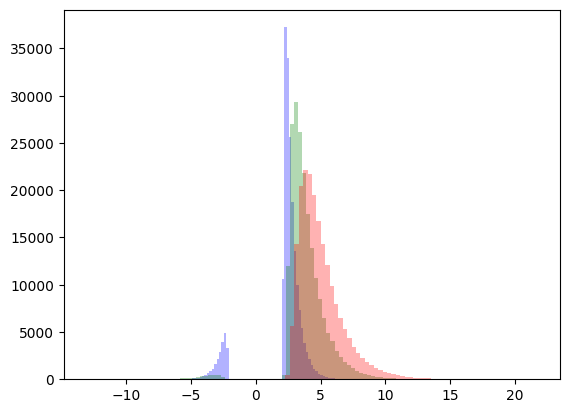

In [70]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.array(out[-2][0,:] * out[-1][0,:]), bins = 100, alpha = 0.3, color = 'blue')
plt.hist(np.array(out[-2][50,:] * out[-1][50,:]), bins = 100, alpha = 0.3, color = 'green')
plt.hist(np.array(out[-2][99,:] * out[-1][99,:]), bins = 100, alpha = 0.3, color = 'red')

In [108]:
array1 = random.normal(key, (100, 10))
array2 = random.normal(key, (10,))

comparison = jax.vmap(lambda x: array1 < x, out_axes = -1)(array2)

In [113]:
comparison[0, :2, :10]

Array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True, False,  True,  True, False, False,  True,
         True]], dtype=bool)

In [29]:
jnp.reshape(jnp.linspace(1, 3, 100), (100, 1))

Array([[1.       ],
       [1.020202 ],
       [1.0404041],
       [1.0606061],
       [1.0808082],
       [1.1010101],
       [1.1212121],
       [1.1414142],
       [1.1616161],
       [1.1818181],
       [1.2020202],
       [1.2222222],
       [1.2424242],
       [1.2626263],
       [1.2828283],
       [1.3030304],
       [1.3232324],
       [1.3434343],
       [1.3636364],
       [1.3838384],
       [1.4040405],
       [1.4242424],
       [1.4444444],
       [1.4646466],
       [1.4848485],
       [1.5050505],
       [1.5252526],
       [1.5454546],
       [1.5656567],
       [1.5858586],
       [1.6060606],
       [1.6262627],
       [1.6464647],
       [1.6666666],
       [1.6868687],
       [1.7070708],
       [1.7272727],
       [1.7474748],
       [1.7676768],
       [1.7878789],
       [1.8080809],
       [1.8282828],
       [1.8484848],
       [1.8686869],
       [1.888889 ],
       [1.9090909],
       [1.929293 ],
       [1.9494951],
       [1.969697 ],
       [1.989899 ],


In [73]:
a = random.normal(key, (100, 1), dtype=jnp.float32)

In [75]:
(a < jnp.zeros((10, 1, 1))).shape

(10, 100, 1)

In [27]:
a

Array([-1.9810703 ,  1.0481724 ,  0.8898191 ,  0.035166  , -0.9473585 ,
        0.85125655,  0.0312455 , -0.38968593,  0.01320801, -0.42052191,
       -1.2335656 , -1.2524313 ,  0.98738754,  0.80595386, -0.41083032,
        0.9738211 , -0.6879051 , -0.79305184, -1.973272  ,  0.15538813,
       -0.5808592 ,  1.5863018 ,  0.28492707,  0.63823265,  0.06069284,
        0.39795223, -0.22721659, -0.7053813 ,  0.6570658 , -1.8061262 ,
        1.0407923 , -1.9712908 , -0.06924485,  0.60396975, -0.38382423,
        0.32502025,  0.28134054, -1.5120755 ,  0.874926  , -0.79578525,
        0.37597522, -0.4551476 ,  0.13549148,  1.2002596 ,  1.7405769 ,
        0.98859143, -0.02708917, -1.184509  , -0.9568104 ,  0.9804613 ,
        0.2211316 ,  0.48654258,  1.6977485 ,  0.20131212, -0.58212173,
       -0.39210144,  0.05007881,  2.0786808 ,  0.1626376 , -0.6914365 ,
        0.48800626,  1.7702677 , -0.05003558,  1.2240386 ,  0.54848504,
        1.6315418 ,  0.46113688, -0.14762828, -0.33743805,  1.65

In [26]:
(a < jnp.zeros((10, 1)))

Array([[ True, False, False, False,  True, False, False,  True, False,
         True,  True,  True, False, False,  True, False,  True,  True,
         True, False,  True, False, False, False, False, False,  True,
         True, False,  True, False,  True,  True, False,  True, False,
        False,  True, False,  True, False,  True, False, False, False,
        False,  True,  True,  True, False, False, False, False, False,
         True,  True, False, False, False,  True, False, False,  True,
        False, False, False, False,  True,  True, False,  True, False,
        False, False, False,  True, False, False,  True, False, False,
        False,  True,  True,  True,  True,  True, False,  True, False,
         True,  True,  True,  True, False,  True,  True, False, False,
         True],
       [ True, False, False, False,  True, False, False,  True, False,
         True,  True,  True, False, False,  True, False,  True,  True,
         True, False,  True, False, False, False, False, Fals

In [136]:
from time import time
time_total = 0
keys = random.split(key, 10000)
for i in range(10000):
    start = time()
    key, subkey = random.split(key)
    random.uniform(subkey, (200000,))
    end = time()
    time_total += (end - start) / 10000




In [156]:
from time import time
time_total = 0
keys = random.split(key, 10000)
for i in range(10000):
    start = time()
    #key, subkey = random.split(keys[i])
    random.normal(keys[i, :], (200000,))
    end = time()
    time_total += (end - start) / 10000


In [162]:
jnp.ones(1000).at[random.normal(key, (1000,)) == 0].set(-9999.)

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [150]:
from time import time
time_total = 0
#keys = random.split(key, 10000)
my_keys = [i^2 for i in range(10000)]
for i in range(10000):
    start = time()
    #key, subkey = random.split(keys[i])
    random.normal(key + my_keys[i], (200000,))
    end = time()
    time_total += (end - start) / 10000

In [148]:
i^2

9997

In [139]:
random.split(key, 1000)

TypeError: JAX encountered invalid PRNG key data: expected key_data to have ndim, shape, and dtype attributes. Got 100

In [138]:
subkey

Array([ 158503457, 2420088358], dtype=uint32)

In [19]:
# jnp.array([True]*100)

In [67]:
jnp.array([20000.]*2000)

Array([20000., 20000., 20000., ..., 20000., 20000., 20000.], dtype=float32)

In [68]:
jnp.array([0.]*2000)

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [70]:
jnp.minimum(jnp.array([0.]*2000), jnp.array([20000.]*2000))

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [20]:
jnp.float32(30)

Array(30., dtype=float32)

In [10]:
out = test_func(0, 20000, key, jnp.zeros(200000), 1)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 8.0000e+00,
        2.0000e+00, 5.0000e+00, 3.0000e+00, 6.0000e+00, 8.0000e+00,
        1.5000e+01, 1.0000e+01, 1.7000e+01, 2.1000e+01, 3.7000e+01,
        2.9000e+01, 4.0000e+01, 7.2000e+01, 8.0000e+01, 9.1000e+01,
        1.0900e+02, 1.5900e+02, 2.1100e+02, 2.5100e+02, 3.0500e+02,
        3.8800e+02, 4.7300e+02, 5.7800e+02, 7.6900e+02, 9.1500e+02,
        1.2520e+03, 1.5440e+03, 1.9170e+03, 2.4470e+03, 3.0200e+03,
        3.8150e+03, 4.9640e+03, 6.1380e+03, 7.6730e+03, 9.7660e+03,
        1.2334e+04, 1.5326e+04, 1.7157e+04, 8.0480e+03, 1.6560e+03,
        1.4849e+04, 1.6593e+04, 1.3674e+04, 1.1033e+04, 8.7680e+03,
        6.9200e+03, 5.5210e+03, 4.3130e+03, 3.3890e+03, 2.7440e+03,
        2.1860e+03, 1.7550e+03, 1.2930e+03, 1.0890e+03, 8.8800e+02,
        7.1000e+02, 5.1700e+02, 4.3400e+02, 3.4500e+02, 2.6100e+02,
        2.1300e+02, 1.5500e+02, 1.4100e+02, 1.13

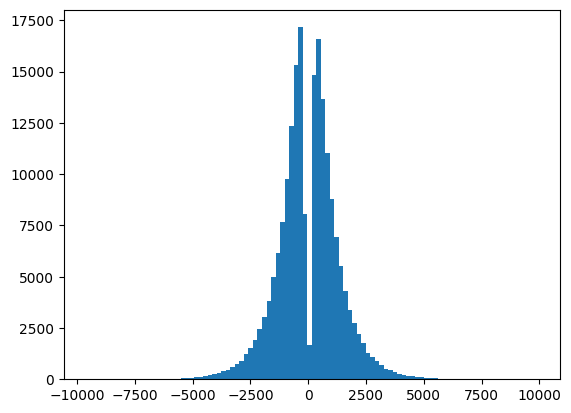

In [176]:
plt.hist(np.squeeze(np.array(out[-1])) * np.squeeze(np.array(out[-2])), bins = 100)

In [105]:
import ssms

In [113]:
from ssms import basic_simulators as bs 

bs.simulator.simulator({'v': 0,
                        'a': 1,
                        'z': 0.5,
                        't': 0.0}, model = 'ddm', n_samples = 200000)



bs.simulator.simulator({'v': 0,
                        'a': 1,
                        'z': 0.5,
                        't': 0.0,
                        'theta': 0.3}, model = 'angle', n_samples = 200000)

passing through
v:  [0.]
a:  [1.]
z:  [0.5]
t:  [0.]


{'rts': array([[1.2020001 ],
        [0.15800014],
        [0.37999865],
        ...,
        [0.2360003 ],
        [0.4149982 ],
        [0.18100019]], dtype=float32),
 'choices': array([[-1],
        [-1],
        [ 1],
        ...,
        [ 1],
        [ 1],
        [ 1]], dtype=int32),
 'metadata': {'v': array([0.], dtype=float32),
  'a': array([1.], dtype=float32),
  'z': array([0.5], dtype=float32),
  't': array([0.], dtype=float32),
  's': 1.0,
  'theta': array([0.3], dtype=float32),
  'delta_t': 0.0010000000474974513,
  'max_t': 20.0,
  'n_samples': 200000,
  'simulator': 'ddm_flexbound',
  'boundary_fun_type': 'angle',
  'possible_choices': [-1, 1],
  'trajectory': array([[ 0.0000000e+00],
         [-3.1195150e-03],
         [ 1.2386636e-02],
         ...,
         [-9.9900000e+02],
         [-9.9900000e+02],
         [-9.9900000e+02]], dtype=float32),
  'boundary': array([ 1.        ,  0.99969065,  0.9993813 , ..., -5.1861067 ,
         -5.1864157 , -5.1867247 ], dtype=float

In [109]:
help(bs.simulator.simulator)

Help on function simulator in module ssms.basic_simulators.simulator:

simulator(theta, model='angle', n_samples=1000, delta_t=0.001, max_t=20, no_noise=False, bin_dim=None, bin_pointwise=False, random_state=None)
    Basic data simulator for the models included in HDDM.
    
    Arguments
    ---------
        theta : list, numpy.array, dict or pd.DataFrame
            Parameters of the simulator. If 2d array, each row is treated as a 'trial'
            and the function runs n_sample * n_trials simulations.
        model: str <default='angle'>
            Determines the model that will be simulated.
        n_samples: int <default=1000>
            Number of simulation runs for each row in the theta argument.
        delta_t: float
            Size fo timesteps in simulator (conceptually measured in seconds)
        max_t: float
            Maximum reaction the simulator can reach
        no_noise: bool <default=False>
            Turn noise of (useful for plotting purposes mostly)
 

(array([2.3824e+04, 4.2425e+04, 3.3891e+04, 2.5450e+04, 1.8726e+04,
        1.4210e+04, 1.0400e+04, 7.9530e+03, 5.8300e+03, 4.4030e+03,
        3.2110e+03, 2.4540e+03, 1.8630e+03, 1.3350e+03, 9.9100e+02,
        7.7700e+02, 5.7600e+02, 4.2200e+02, 3.2300e+02, 2.4600e+02,
        1.8700e+02, 1.3000e+02, 9.0000e+01, 7.2000e+01, 4.6000e+01,
        3.8000e+01, 3.2000e+01, 1.9000e+01, 1.6000e+01, 1.6000e+01,
        1.3000e+01, 1.4000e+01, 4.0000e+00, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  43.        ,  289.5249939 ,  536.04998779,  782.57501221,
        1029.09997559, 1275.625     , 1522.15002441, 1768.67504883,
        2015.19995117, 2261.72509766, 2508.25      , 2754.77490234,
        3001.30004883, 3247.82495117, 3494.35009766, 3740.875     ,
        3987.39990234, 4233.92480469, 4480.45019531, 4726.97509766,
        4973.5       , 5220.02490234, 5466.54980469, 5713.07519531,
        5959.60009766, 6206.125     , 6452.649

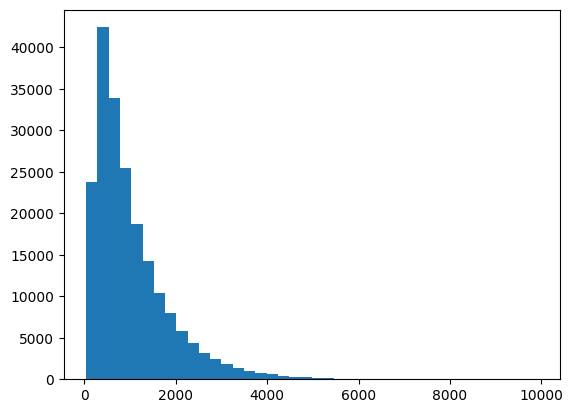

In [104]:
plt.hist(np.squeeze(np.array(out[-1])), bins = 40)

In [95]:
out[-1][(out[0] > 1) | (out[0] < -1)]

Array([20000., 20000., 20000., ..., 20000., 20000., 20000.], dtype=float32)

(array([116., 111., 109., 107., 133., 125.,  93., 107.,  94., 115.]),
 array([-0.9961378 , -0.79662728, -0.59711683, -0.39760634, -0.19809586,
         0.00141463,  0.20092511,  0.4004356 ,  0.59994608,  0.7994566 ,
         0.99896705]),
 <BarContainer object of 10 artists>)

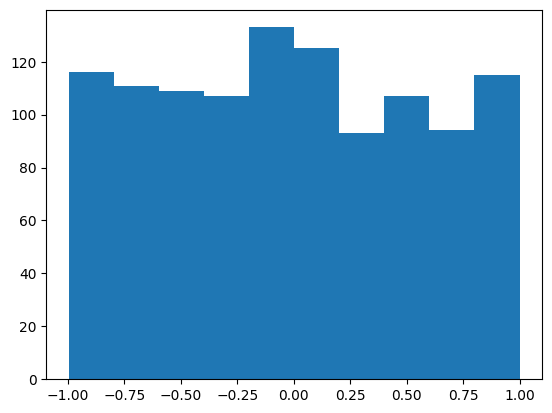

In [92]:
plt.hist(np.array(out[0][(out[0] < 1) & (out[0] > -1)]))

(array([     0.,      0.,      0.,      0.,      0., 200000.,      0.,
             0.,      0.,      0.]),
 array([19999.5       , 19999.59960938, 19999.69921875, 19999.80078125,
        19999.90039062, 20000.        , 20000.09960938, 20000.19921875,
        20000.30078125, 20000.40039062, 20000.5       ]),
 <BarContainer object of 10 artists>)

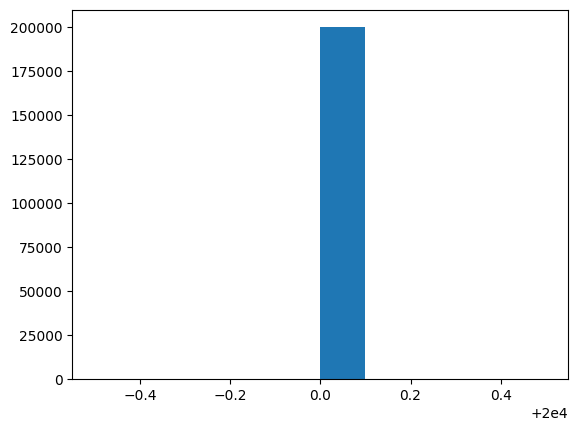

In [86]:
from matplotlib import pyplot as plt
import numpy as np
plt.hist(np.squeeze(np.array(out[-1])))

In [74]:
random.normal(key, (1000,), dtype=jnp.float32)

Array([-1.57218266e+00, -5.87747276e-01, -1.54195279e-01, -6.89078331e-01,
        6.59210980e-01,  2.98236817e-01,  7.42171943e-01,  1.01931739e+00,
        1.74980617e+00,  1.04546618e+00,  1.15095198e+00,  9.73630548e-02,
       -2.42641587e-02, -1.37085021e+00,  2.01606393e-01, -4.30584222e-01,
       -1.48145169e-01,  6.33104563e-01, -9.30495083e-01, -4.83479768e-01,
        2.06030443e-01,  7.20419586e-01, -8.82625997e-01, -5.12911558e-01,
        7.93567061e-01, -5.04700005e-01,  1.14157486e+00, -6.53433800e-01,
        4.33537811e-01,  7.46298730e-01,  3.00492525e-01,  2.67056346e-01,
       -1.15867160e-01, -2.41305470e-01,  5.91683924e-01, -1.22448909e+00,
       -1.25146890e+00,  3.76878306e-04,  1.28927028e+00, -5.97998798e-01,
        1.77729353e-02, -1.60173106e+00, -1.79757130e+00,  4.27672714e-01,
       -9.32130396e-01, -1.22382665e+00, -6.77089334e-01, -3.03168368e+00,
        3.77068073e-01,  7.39320815e-01, -1.09874082e+00,  1.03309345e+00,
        1.62717533e+00, -

In [9]:
jax.lax.fori_loop()

TypeError: fori_loop() missing 4 required positional arguments: 'lower', 'upper', 'body_fun', and 'init_val'

In [75]:
start = time()
for i in range(10):
    x = (random.normal(key +  i + 100, (20000, 20000), dtype=jnp.float32))
end = time()

print((end - start) / 10)

NameError: name 'time' is not defined

In [12]:
key = random.PRNGKey(0)
dt = 0.001
dt_sqrt = jnp.sqrt(dt)
drift = jnp.ones((20000, 1)) * 2
drift_increment = drift * dt
bound_base = jnp.ones((20000, 1)) * 2

# for j in range(10):
#     start_x = time()
#     x = (random.normal(key + 100 + j, (20000, 20000), dtype=jnp.float32)) * dt_sqrt
#     end_x = time()
#     times_x.append(end_x - start_x)
#     for i in range(100):
#         print(i, j)
#         start = time()
#         # x = (random.normal(key + i*j + 100, (20000, 20000), dtype=jnp.float32))
#         my_rts.append(prod_rts_from_rng(x, 
#                       bound = bound_base * bounds[i], dt = dt, drift = drift))
#         end = time()
#         times.append(end - start)

In [13]:
random.PRNKey()

Array([0, 0], dtype=uint32)

In [42]:
from time import time
import numpy as np

@jax.jit
def prod_rts_from_rng(x, bound, dt, drift):
    dt_sqrt = jnp.sqrt(dt)
    drift_increment = drift * dt
    y = jnp.cumsum(x + drift_increment, axis = 1)
    rt_ids = jnp.argmax((y > bound) | (y < -bound), axis = 1)
    rt_signs = jnp.sign(y[jnp.arange(y.shape[0]), rt_ids])
    rts = rt_ids * rt_signs * dt
    return rts
    # return rts

bounds = np.linspace(1, 3, 100).astype(np.float32)
my_rts = []
times = []
times_x = []

n_parallel_samples = 20000
n_steps = 20000

key = random.PRNGKey(0)
dt = jnp.float32(0.001)
dt_sqrt = jnp.sqrt(dt)
drift = jnp.ones((1, n_steps), dtype = jnp.float32) * 2
drift_increment = drift * dt
bound_base = jnp.ones((1, n_steps), dtype = jnp.float32)
x = (random.normal(subkey, (n_parallel_samples, n_steps), dtype=jnp.float32)) * dt_sqrt
for j in range(10):
    #start_x = time()
    key, subkey = random.split(key)
    x.at[:,:].set((random.normal(subkey, (n_parallel_samples, n_steps), dtype=jnp.float32)) * dt_sqrt)
    #end_x = time()
    #times_x.append(end_x - start_x)
    for i in range(100):
        # print(i, j)
        # start = time()
        # x = (random.normal(key + i*j + 100, (20000, 20000), dtype=jnp.float32))
        my_rts.append(np.array(prod_rts_from_rng(x, 
                        bound = bound_base * bounds[i], dt = dt, drift = drift)))
        # end = time()
        # times.append(end - start)

In [ ]:

# try:
#     x = (random.normal(subkey, (n_parallel_samples, n_steps), dtype=jnp.float32)) * dt_sqrt
# except Error:
#     print(Error. )

    


(array([3.66302691e-04, 7.32605382e-04, 0.00000000e+00, 7.32605382e-04,
        1.46521076e-03, 2.19781615e-03, 4.39563229e-03, 5.49454037e-03,
        9.15756728e-03, 1.24542915e-02, 1.57510157e-02, 2.38096749e-02,
        3.04031234e-02, 1.53847130e-02, 8.79126458e-03, 1.11942102e+00,
        1.83444388e+00, 1.42931310e+00, 1.00110525e+00, 6.21981969e-01,
        4.23812214e-01, 2.66668359e-01, 1.81686135e-01, 1.18682072e-01,
        6.84986032e-02, 4.87182579e-02, 2.78390045e-02, 1.68499238e-02,
        1.09890807e-02, 8.42496189e-03, 4.02932960e-03, 5.49454037e-03,
        2.93042153e-03, 1.46521076e-03, 1.09890807e-03, 0.00000000e+00,
        3.66302691e-04, 7.32605382e-04, 0.00000000e+00, 3.66302691e-04]),
 array([-1.96903598, -1.83253685, -1.69603772, -1.55953858, -1.42303945,
        -1.28654031, -1.15004118, -1.01354205, -0.87704291, -0.74054378,
        -0.60404465, -0.46754551, -0.33104638, -0.19454724, -0.05804811,
         0.07845102,  0.21495016,  0.35144929,  0.48794842,

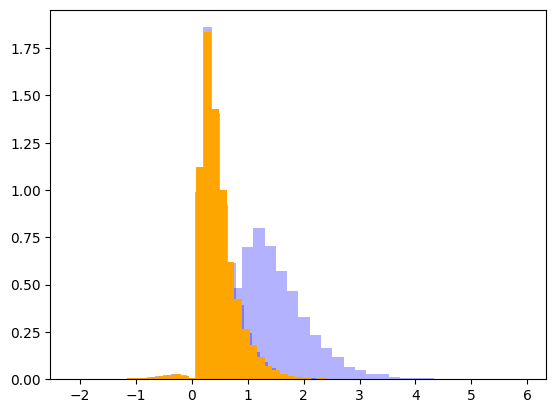

In [35]:
from matplotlib import pyplot as plt

plt.hist(my_rts[0], bins = 40, alpha = 0.3, color = 'blue', density = True)
plt.hist(my_rts[99], bins = 40, alpha = 0.3, color = 'blue', density = True)
plt.hist(np.squeeze(out_low_bound['rts'] * out_low_bound['choices']), bins = 40, color = 'orange', density = True)

(array([2.02063472e-02, 1.27299987e-01, 3.41150495e-01, 5.55337776e-01,
        7.59421882e-01, 7.96130080e-01, 7.71208918e-01, 6.67819775e-01,
        5.77227985e-01, 4.84952333e-01, 3.63714250e-01, 3.09830657e-01,
        2.46517436e-01, 1.72090724e-01, 1.38413478e-01, 1.00358191e-01,
        7.51002571e-02, 5.99454967e-02, 4.20965567e-02, 3.03095208e-02,
        2.32372993e-02, 1.91960298e-02, 1.24605808e-02, 1.21238083e-02,
        5.05158680e-03, 6.06190416e-03, 4.04126944e-03, 3.70449699e-03,
        4.04126944e-03, 3.36772453e-04, 6.73544907e-04, 1.01031736e-03,
        6.73544907e-04, 1.34708981e-03, 3.36772453e-04, 1.68386227e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36772453e-04]),
 array([0.34599909, 0.49446729, 0.64293549, 0.79140369, 0.93987189,
        1.08834009, 1.23680829, 1.38527649, 1.53374469, 1.68221289,
        1.83068109, 1.97914929, 2.12761749, 2.27608569, 2.42455389,
        2.57302209, 2.72149029, 2.86995849, 3.01842669, 3.16689489,
      

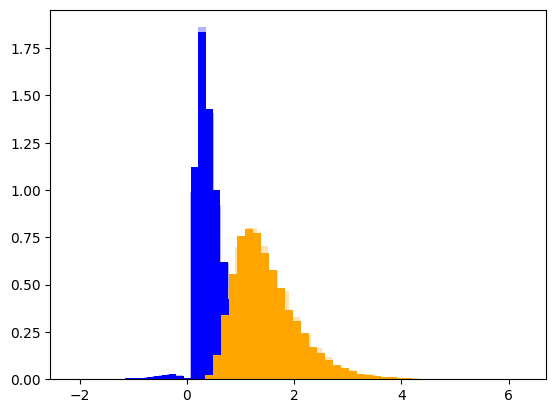

In [40]:
plt.hist(my_rts[0], bins = 40, alpha = 0.3, color = 'blue', density = True)
plt.hist(my_rts[99], bins = 40, alpha = 0.3, color = 'orange', density = True)
plt.hist(np.squeeze(out_low_bound['rts'] * out_low_bound['choices']), bins = 40, color = 'blue', density = True)
plt.hist(np.squeeze(out_high_bound['rts'] * out_high_bound['choices']), bins = 40, color = 'orange', density = True)


In [17]:
out_low_bound['choices']

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [25]:
from ssms import basic_simulators as bs

out_low_bound = bs.simulator.simulator(theta = [2, 1, 0.5, 0.0], model = 'ddm', n_samples = 20000)
out_high_bound = bs.simulator.simulator(theta = [2, 3, 0.5, 0.0], model = 'ddm', n_samples = 20000)

passing through
v:  [2.]
a:  [1.]
z:  [0.5]
t:  [0.]
passing through
v:  [2.]
a:  [3.]
z:  [0.5]
t:  [0.]


In [ ]:
help(bs.simulator.simulator)

Help on function simulator in module ssms.basic_simulators.simulator:

simulator(theta, model='angle', n_samples=1000, delta_t=0.001, max_t=20, no_noise=False, bin_dim=None, bin_pointwise=False, random_state=None)
    Basic data simulator for the models included in HDDM.
    
    Arguments
    ---------
        theta : list, numpy.array, dict or pd.DataFrame
            Parameters of the simulator. If 2d array, each row is treated as a 'trial'
            and the function runs n_sample * n_trials simulations.
        model: str <default='angle'>
            Determines the model that will be simulated.
        n_samples: int <default=1000>
            Number of simulation runs for each row in the theta argument.
        delta_t: float
            Size fo timesteps in simulator (conceptually measured in seconds)
        max_t: float
            Maximum reaction the simulator can reach
        no_noise: bool <default=False>
            Turn noise of (useful for plotting purposes mostly)
 

In [ ]:
out['rts'].mean()

2.4462798

In [ ]:
help(ssms.basic_simulators.simulator)

Help on module ssms.basic_simulators.simulator in ssms.basic_simulators:

NAME
    ssms.basic_simulators.simulator

FUNCTIONS
    bin_arbitrary_fptd(out=None, bin_dt=0.04, nbins=256, nchoices=2, choice_codes=[-1.0, 1.0], max_t=10.0)
        Takes in simulator output and returns a histogram of bin counts
        Arguments
        ---------
            out: tuple
                Output of the 'simulator' function
            bin_dt : float
                If nbins is 0, this determines the desired bin size
                which in turn automatically determines the resulting number of bins.
            nbins : int
                Number of bins to bin reaction time data into.
                If supplied as 0, bin_dt instead determines the number of
                bins automatically.
            nchoices: int <default=2>
                Number of choices allowed by the simulator.
            choice_codes = list <default=[-1.0, 1.0]
                Choice labels to be used.
            max

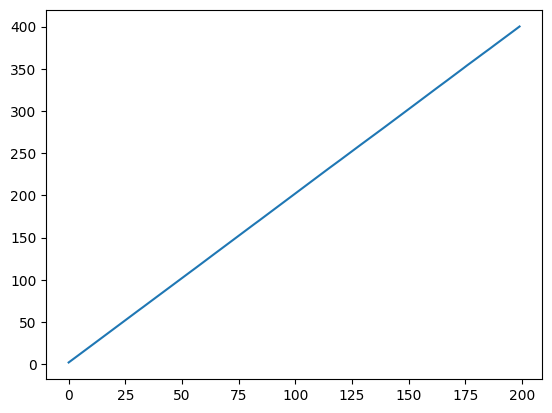

In [ ]:
from matplotlib import pyplot as plt
plt.plot(my_rts[0][0, :200])

Array([0.29900002, 0.48700002, 0.312     , ..., 0.316     , 0.20400001,
       0.395     ], dtype=float32)

(array([3.100e+01, 1.200e+02, 3.410e+02, 6.790e+02, 8.420e+02, 9.940e+02,
        1.015e+03, 9.570e+02, 8.530e+02, 7.380e+02, 6.870e+02, 5.560e+02,
        4.690e+02, 3.640e+02, 2.920e+02, 2.300e+02, 1.720e+02, 1.630e+02,
        1.100e+02, 9.600e+01, 6.700e+01, 6.200e+01, 2.700e+01, 3.500e+01,
        1.700e+01, 2.500e+01, 1.600e+01, 1.000e+01, 8.000e+00, 7.000e+00,
        5.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([0.35800001, 0.48717502, 0.61635   , 0.745525  , 0.87470001,
        1.00387502, 1.13304996, 1.26222503, 1.39139998, 1.52057505,
        1.64974999, 1.77892506, 1.90810001, 2.03727508, 2.16645002,
        2.29562497, 2.42480016, 2.55397511, 2.68315005, 2.812325  ,
        2.94149995, 3.07067513, 3.19985008, 3.32902503, 3.45819998,
        3.58737516, 3.71655011, 3.84572506, 3.97490001, 4.10407495,
        4.23325014, 4.36242485, 4.49160004, 4.62077522, 4.74994993,
        4.87912512, 5.0083

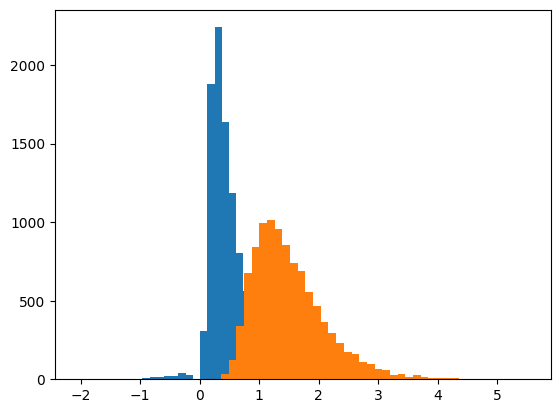

In [ ]:
plt.hist(my_rts[0], bins = 40)
plt.hist(my_rts[99], bins = 40)

In [ ]:
y = random.permutation(key + 1, x, axis = 1)

In [ ]:
key + 1

Array([1, 1], dtype=uint32)

In [ ]:
pos_rt = jnp.sum((x > 1), axis = 1)
neg_rt = jnp.sum((x < -1), axis = 1)

In [ ]:
rt_ids = jnp.argmax((x > 1) | (x < -1), axis = 1)

In [ ]:
rt_signs = jnp.sign(x[jnp.arange(x.shape[0]), rt_ids])
#rts = 

In [ ]:
rts = rt_ids * rt_signs * 0.001

In [ ]:
#jnp.sum(rt_signs)

rts

Array([0.29900002, 0.48700002, 0.312     , ..., 0.316     , 0.20400001,
       0.395     ], dtype=float32)

In [ ]:
jnp.where(pos_rt > neg_rt)

(10000,)

In [ ]:
my_ids[0]

(193703590,)

In [ ]:
x[my_ids] * x

Array([ 1.0185593,  1.0281496,  1.0374309, ..., 44.80053  , 44.770485 ,
       44.791817 ], dtype=float32)

In [ ]:
#y = jnp.cumsum(z, axis = 1)
rts = jnp.sum((x < 1) & (x > -1), axis = 1) / 1000

In [ ]:
x[jnp.array([[0,1], [1, 3]])].shape

(2, 2, 20000)

In [ ]:
#rts.shape

(10000,)

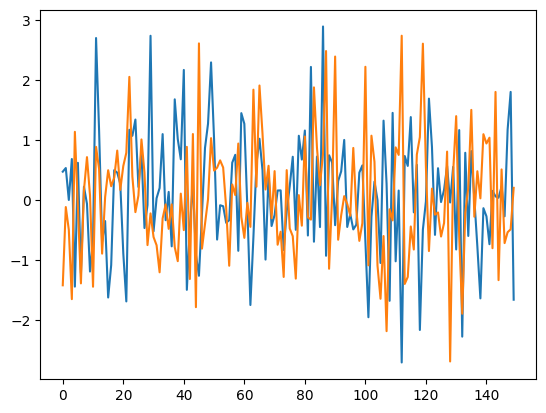

In [ ]:
from matplotlib import pyplot as plt
plt.plot(x[0, :1000])
plt.plot(x[1, :1000])

(array([1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        3.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 1.500e+01, 1.700e+01,
        1.800e+01, 2.300e+01, 4.100e+01, 2.500e+01, 4.000e+00, 3.070e+02,
        1.878e+03, 2.240e+03, 1.640e+03, 1.188e+03, 8.050e+02, 5.610e+02,
        3.940e+02, 2.490e+02, 1.900e+02, 1.330e+02, 8.200e+01, 6.200e+01,
        3.100e+01, 2.700e+01, 1.400e+01, 1.100e+01, 6.000e+00, 5.000e+00,
        7.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([-2.05400014, -1.93262517, -1.81125009, -1.68987513, -1.56850016,
        -1.44712508, -1.32575011, -1.20437515, -1.08300006, -0.9616251 ,
        -0.84025007, -0.71887505, -0.59750009, -0.47612506, -0.35475004,
        -0.23337504, -0.11200003,  0.00937497,  0.13074997,  0.25212499,
         0.37349999,  0.49487498,  0.61624998,  0.737625  ,  0.85900003,
         0.98037505,  1.10175002,  1.22312498,  1.34450006,  1.46587503,
         1.58724999,  1.70862508,  1.83000004,  1.95137513,  2.0

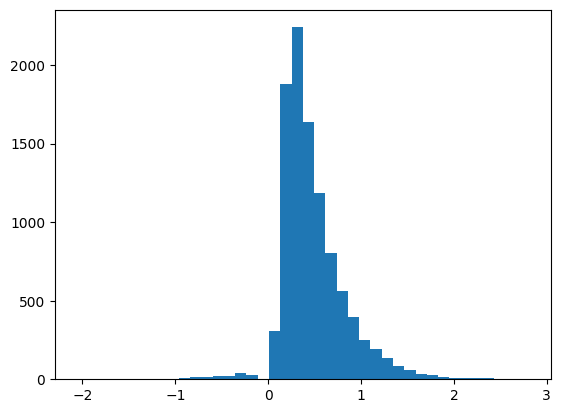

In [ ]:
plt.hist(rts,  bins = 40)

#### Using `jit()`

In [ ]:
def selu(x, alpha = 1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = random.normal(key, (1000000, ))
%timeit selu(x).block_until_ready()

1.98 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

403 µs ± 7.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)

derivative_fn = grad(sum_logistic)

print(derivative_fn(x_small))

[0.25       0.19661197 0.10499357]


In [ ]:
jnp.arange(3.)

DeviceArray([0., 1., 2.], dtype=float32)

#### Using `vmap()`

In [ ]:
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
    return jnp.dot(mat, v)

In [ ]:
def naively_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])

In [ ]:
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

1.4 ms ± 3.22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### A simple Training loop in JAX

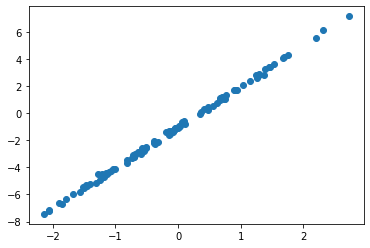

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size = (100, ))
noise = np.random.normal(scale = 0.1, size = (100, ))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys)

In [ ]:
def model(theta, x):
    """Computes wx + b on a batch of input x."""
    w, b = theta
    return w * x + b

In [ ]:
def loss_fn(theta, x, y):
    prediction = model(theta, x)
    return jnp.mean((prediction - y) ** 2)

In [ ]:
def update(theta, x, y, lr=0.1):
    return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 3.00, b: -1.02


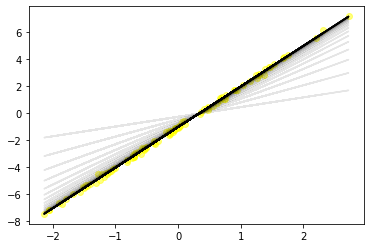

In [ ]:
theta = jnp.array([0., 0.])
for _ in range(50):
  theta = update(theta, xs, ys)
  plt.plot(xs, model(theta, xs), alpha = 0.10, color = 'black')

plt.scatter(xs, ys, color = 'yellow', alpha = 0.5)

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

#### Higher Order Derivatives

##### Scalar case

In [ ]:
f = lambda x: x**3 + 2*x**2 - 3*x + 1
dfdx = jax.grad(f)
d2fdx = jax.grad(dfdx)

In [ ]:
print(dfdx(1.0))
print(d2fdx(1.0))

4.0
10.0


##### Multivariate case

In [ ]:
def hessian(f):
    return jax.jacfwd(jax.grad(f))

def hessian_naive(f):
    return jax.jacrev(jax.grad(f))

In [ ]:
def f(x):
    return jnp.dot(x, x)

In [ ]:
%timeit hessian(f)(jnp.array([1., 2., 3.]))

2.97 ms ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit hessian_naive(f)(jnp.array([1., 2., 3.]))

3.77 ms ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Random Numbers

In [ ]:
from jax import random

key = random.PRNGKey(42)
print(key)

[ 0 42]


In [ ]:
print(random.normal(key))
print(random.normal(key))

-0.18471177
-0.18471177


Instead of reusing keys, we want to generate new keys all the time.

In [ ]:
print("old key", key)
new_key, subkey = random.split(key)
del key  # The old key is discarded -- we must never use it again.
normal_sample = random.normal(subkey)
print(r"    \---SPLIT --> new key   ", new_key)
print(r"             \--> new subkey", subkey, "--> normal", normal_sample)
del subkey  # The subkey is also discarded after use.

# Note: you don't actually need to `del` keys -- that's just for emphasis.
# Not reusing the same values is enough.

key = new_key  # If we wanted to do this again, we would use new_key as the key.

old key [ 0 42]
    \---SPLIT --> new key    [2465931498 3679230171]
             \--> new subkey [255383827 267815257] --> normal 1.3694694


One more example illustrating key behavior.

In [ ]:
key = random.PRNGKey(42)
subkeys = random.split(key, 3)
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(42)
print("all at once: ", random.normal(key, shape=(3,)))

individually: [-0.04838832  0.10796154 -1.2226542 ]
all at once:  [ 0.18693547 -1.2806505  -1.5593132 ]


#### pytree s

In [ ]:
import jax
import jax.numpy as jnp

example_trees = [
                    [1, 'a', object()],
                    (1, (2, 3), ()),
                    [1, {'k1': 2, 'k2': (3, 4)}, 5],
                    {'a': 2, 'b': (2, 3)},
                    jnp.array([1, 2, 3]),
                 ]

# Let's see how many leaves they have:
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f508dec4850>]   has 3 leaves: [1, 'a', <object object at 0x7f508dec4850>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


#### pytrees for MLP training

In [ ]:
import numpy as np

def init_mlp_params(layer_widths):
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                 biases=np.ones(shape=(n_out,))
                )
        )
    return params

params = init_mlp_params([1, 128, 128, 1])

In [ ]:
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [ ]:
def forward(params, x):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params, x, y):
    grads = jax.grad(loss_fn)(params, x, y)
    # Note that `grads` is a pytree with the same structure as `params`.
    # `jax.grad` is one of the many JAX functions that has
    # built-in support for pytrees.

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_map(lambda p, 
                        g: p - LEARNING_RATE * g, 
                        params, 
                        grads)

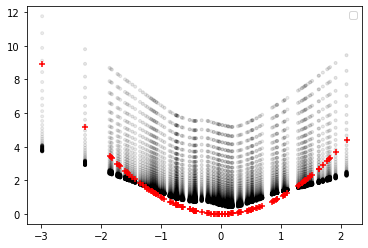

In [ ]:
import matplotlib.pyplot as plt

params = init_mlp_params([1, 128, 128, 1])

xs = np.random.normal(size=(128, 1))
ys = xs ** 2

for _ in range(100):
  params = update(params, xs, ys)
  plt.scatter(xs, forward(params, xs), alpha = (10 + i) / 110, marker = '.',
             color = 'black')

plt.scatter(xs, ys, marker = '+', color = 'red')
#plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

#### transposing pytrees

In [ ]:
def tree_transpose(list_of_trees):
  """Convert a list of trees of identical structure into a single tree of lists."""
  return jax.tree_map(lambda *xs: list(xs), *list_of_trees)

# Convert a dataset from row-major to column-major:
episode_steps = [dict(t=1, obs=3), dict(t=2, obs=4)]
tree_transpose(episode_steps)

{'obs': [3, 4], 't': [1, 2]}

In [ ]:
*lot = episode_steps

SyntaxError: starred assignment target must be in a list or tuple (<ipython-input-106-b302c791ec12>, line 4)